In [1]:
import pandas as pd
from nltk.corpus import stopwords
import nltk
import pymorphy2
import re
import string
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from datetime import datetime

tqdm.pandas()
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')

from multiprocessing import Pool
morph = pymorphy2.MorphAnalyzer()

import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mchelushkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
commentsDF = pd.read_csv('commentsRAW.csv', usecols=['id', 'date', 'text'])
answersDF = pd.read_csv('answersRAW.csv', usecols=['id', 'date', 'text'])
commentsDF = commentsDF[commentsDF.text.notna()]
answersDF = answersDF[answersDF.text.notna()]

In [3]:
allCommentsDF = commentsDF.append(answersDF, ignore_index=True)
allCommentsDF.shape

(1433391, 3)

In [4]:
sortedDF = allCommentsDF.sort_values(by=['date'])

In [5]:
# вк собака объединяет символы - ковычки и троеточия
punctuation = string.punctuation + '…«»—–'
def clean_text(text):
# Make text lowercase
    text = text.lower()
# remove text in square brackets
    text = re.sub(r'\[.*?\]', ' ', text)
# remove urls
    text = re.sub(r"http\S+", ' ', text)
# remove punctuation
    text = re.sub(r'[%s]' % re.escape(punctuation), ' ', text)
# remove numbers
    text = re.sub(r'[0-9]', ' ', text)
# remove non letters
    text = re.sub(r'[^\w\s]', '', text)
# remove dublicate spaces
    text = re.sub('\s\s+', ' ', text)
    return text
# comments_df_clean = pd.DataFrame(allCommentsDF.text.progress_apply(lambda x: clean_text(x)))
comments_df_clean = pd.DataFrame(sortedDF.text.progress_apply(lambda x: clean_text(x)))

100%|██████████| 1433391/1433391 [00:31<00:00, 45150.58it/s]


In [6]:
%%time

stopwords_list = stopwords.words('russian') + stopwords.words('english')
stopwords_list.append('это')
stopwords_list.append('всё')
stopwords_list.append('ещё')
stopwords_list.append('весь')
stopwords_list.append('человек')
stopwords_list.append('свой')
stopwords_list.append('который')
stopwords_list.append('мочь')
stopwords_list.append('')
stopwords_list.append('p')
stopwords_list.append('c')
stopwords_list.append('de')
stopwords_list.append('b')
stopwords_list.append('ваш')
stopwords_list.append('либо')

def lemmatize(text, lemmer = morph, stopwords = stopwords_list):
    words = text.split(' ')
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if len(w) >= 3 and not w in stopwords]

with Pool(processes = 4) as pool:
    lemmatized = pool.starmap(lemmatize, zip(comments_df_clean.text))

CPU times: user 9.8 s, sys: 1.39 s, total: 11.2 s
Wall time: 6min 9s


In [13]:
import json
with open('DTM/lemmatized.json', 'w') as f:
    f.write(json.dumps(lemmatized))

In [5]:
import json
with open('DTM/lemmatized.json', 'r') as f:
    lemmatized = json.loads(f.read())

In [7]:
comments_lemmatized_df = pd.DataFrame({'text' : lemmatized, 'date' : sortedDF.date})

In [8]:
comments_lemmatized_df

,text,date
74436,"[вирус, искусственно, создаваться, очень, прос...",1578731693
74437,"[снова, фармацевт, накидывать, гно, вентилятор]",1578731707
74438,"[кошмарить, специально, публикация, проплатить...",1578731950
74439,"[вначале, нужно, народ, напугать, прививка, пр...",1578732111
74440,"[палка, конец, реально, болячка, просто, вброс...",1578732496
...,...,...
871868,"[собираться, собраться, привить, вопрос, время...",1618727698
871567,"[ниточка, потерять, написать, развалиться, рез...",1618738485
871755,"[идиот, думать, работать, пропаганда, образ, в...",1618738631
871568,"[рассказать, бобёр, тупой, чушь, почитай, хала...",1618739068


In [9]:
def wordsCount(texts):
    count = Counter()
    for words in texts:
        for word in words:
            count[word] += 1
    return count

def removeNotCommonWords(text, word_counter):
    return [word for word in text if word_counter[word] > 10]

def func(df):
    word_counter = wordsCount(df.text.values.tolist())
    
    df.text = df.text.apply(lambda x: removeNotCommonWords(x, word_counter))
    df.text = df.text.apply(lambda x: ' '.join(x))
    df.text = df.text.apply(lambda x: x.split())
    df = df[df.text.apply(lambda x: len(x) >= 20 and len(x) <= 300)]
    return df

In [10]:
clean_texts = func(comments_lemmatized_df)

In [11]:
clean_texts

,text,date
74448,"[продолжать, ходить, нараспашку, шапка, дурь, ...",1578754224
489703,"[китаец, отверстие, достойный, пропасть, падши...",1578784658
410860,"[вирус, мутировать, постоянно, приспосабливать...",1579249273
172619,"[такса, пацан, начинать, южный, африка, качать...",1579550779
172647,"[удивительно, коммент, обвинение, адрес, кремл...",1579552723
...,...,...
871736,"[лола, чел, топить, капитализм, сказочно, бога...",1618649356
871744,"[думать, наверное, стоить, говорить, комментар...",1618657447
871566,"[мнение, провокация, уметь, беседа, держать, н...",1618691778
871567,"[ниточка, потерять, написать, развалиться, рез...",1618738485


In [12]:
tmp_cleaned_texts = clean_texts.copy()
tmp_cleaned_texts['formated_date'] = tmp_cleaned_texts.date.apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%V'))
tmp_cleaned_texts = tmp_cleaned_texts[3:]
tmp_cleaned_texts

,text,date,formated_date
172619,"[такса, пацан, начинать, южный, африка, качать...",1579550779,2020-04
172647,"[удивительно, коммент, обвинение, адрес, кремл...",1579552723,2020-04
172651,"[любой, эпидемия, грипп, число, умерший, дости...",1579552944,2020-04
1175053,"[часть, учитывать, свиной, паника, друг, аптек...",1579554159,2020-04
1174906,"[верно, старина, спорить, спасибо, краткий, ди...",1579555102,2020-04
...,...,...,...
871736,"[лола, чел, топить, капитализм, сказочно, бога...",1618649356,2021-15
871744,"[думать, наверное, стоить, говорить, комментар...",1618657447,2021-15
871566,"[мнение, провокация, уметь, беседа, держать, н...",1618691778,2021-15
871567,"[ниточка, потерять, написать, развалиться, рез...",1618738485,2021-15


In [13]:
time_slice = tmp_cleaned_texts.groupby(['formated_date']).count().date.values

In [14]:
time_slice

array([ 471, 1116,  865,  912,  929, 1486, 1370, 2220, 4983, 8059, 9856,
       9346, 9687, 7608, 6866, 6401, 4707, 3771, 3016, 2581, 1899, 1800,
       1973, 1332, 1416, 1147, 1215, 1056,  917, 1114,  837,  641,  891,
        956,  998, 1431, 1844, 1896, 1971, 2037, 1857, 1787, 2005, 1761,
       1904, 1965, 1294, 1437, 1345,  527, 1227, 1251, 1013, 1039,  925,
        948,  799,  908,  992, 1049, 1125,  716,  410,  464,  477,  296])

In [15]:
dictionary = corpora.Dictionary(tmp_cleaned_texts.text)

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('lda.dict')

In [16]:
corpus = [dictionary.doc2bow(text) for text in tmp_cleaned_texts.text]
corpora.MmCorpus.serialize('lda_gensim.model', corpus)

In [14]:
import logging
import os
from gensim import corpora, utils
from gensim.models.wrappers.dtmmodel import DtmModel
import numpy as np

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [15]:
logger.setLevel(logging.CRITICAL)

In [40]:
%%time
dtm_path = "/home/mchelushkin/Downloads/dtm-linux64"

model = DtmModel(dtm_path, corpus, time_slice, num_topics=8, id2word=dictionary, initialize_lda=True)

CPU times: user 1min 16s, sys: 617 ms, total: 1min 16s
Wall time: 5h 21min 26s


In [17]:
model.save('DTM/models/n8/dtm_n8.model')

In [21]:
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.corpora import Dictionary, bleicorpus
import pyLDAvis
pyLDAvis.enable_notebook()

doc_topic, topic_term, doc_lengths, term_frequency, vocab = model.dtm_vis(time=10, corpus=corpus)
vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_wrapper)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
/home/mchelushkin/anaconda3/lib/python3.8/site-packages/joblib/numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))


In [27]:
from matplotlib.pyplot import figure
def visByTopicId(model, topicid, topn):
    bestWordsForTime = {}
    for time in range(66):
        topicWords = model.show_topic(topicid, time=time, topn=topn)
        for prob, word in topicWords:
            if word in bestWordsForTime:
                bestWordsForTime[word].append((time, prob))
            else:
                bestWordsForTime[word] = [(time, prob)]
    
    figure(figsize=(8, 6), dpi=80)
    for name in bestWordsForTime:
        tmp = dict(bestWordsForTime[name])
        for i in range(66):
            if i not in tmp:
                tmp[i] = None
        idcs = np.argsort(list(tmp.keys()))
        x = np.array(list(tmp.keys()))[np.argsort(list(tmp.keys()))]
        y = np.array(list(tmp.values()))[np.argsort(list(tmp.keys()))]
        plt.plot(x, y, label=name)
    plt.xlabel('week number')
    plt.ylabel('prob')
    plt.legend()
    plt.savefig('dtm.png')
    return plt

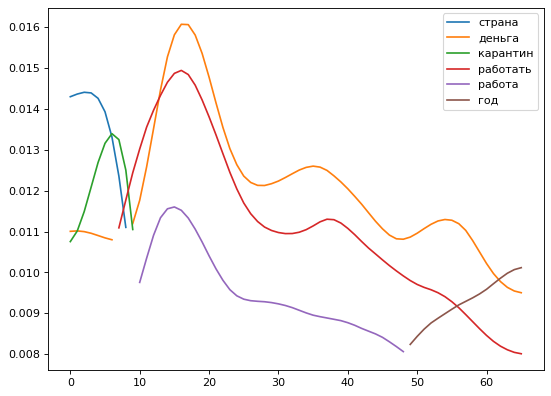

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [19]:
visByTopicId(model, topicid = 0, topn = 3)

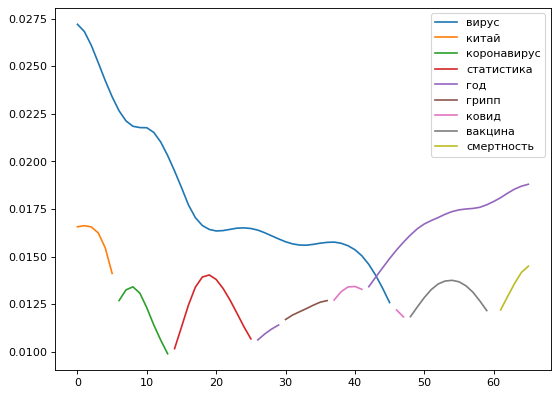

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [21]:
visByTopicId(model, topicid = 1, topn = 2)

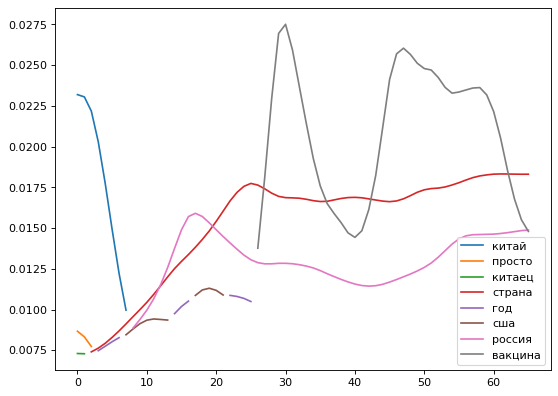

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [22]:
visByTopicId(model, topicid = 3, topn = 3)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


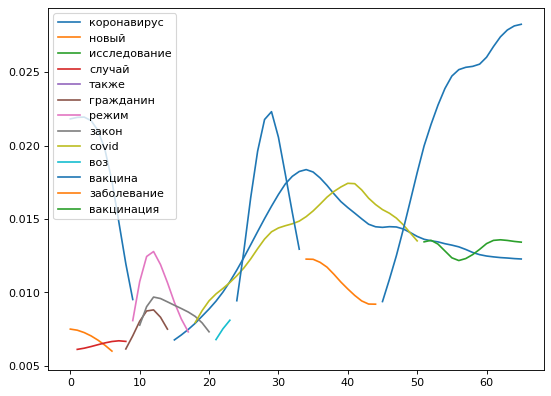

In [50]:
visByTopicId(model, topicid = 4, topn = 3)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


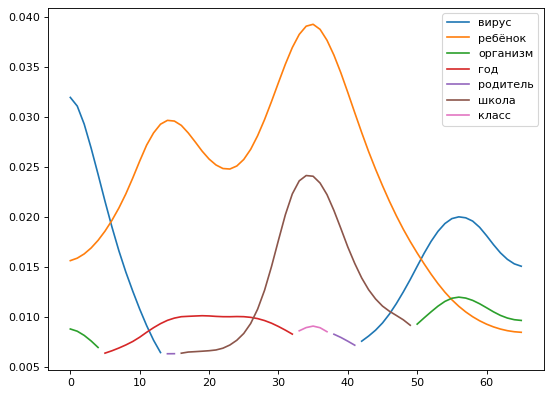

In [51]:
visByTopicId(model, topicid = 5, topn = 3)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


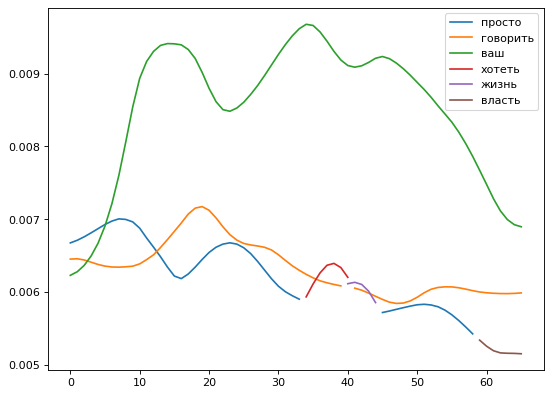

In [52]:
visByTopicId(model, topicid = 6, topn = 3)

/home/mchelushkin/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


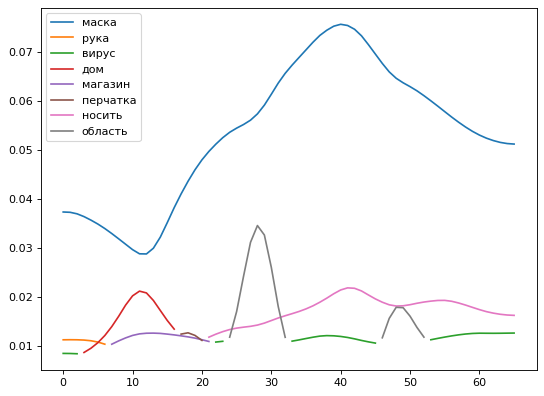

In [53]:
visByTopicId(model, topicid = 7, topn = 3)

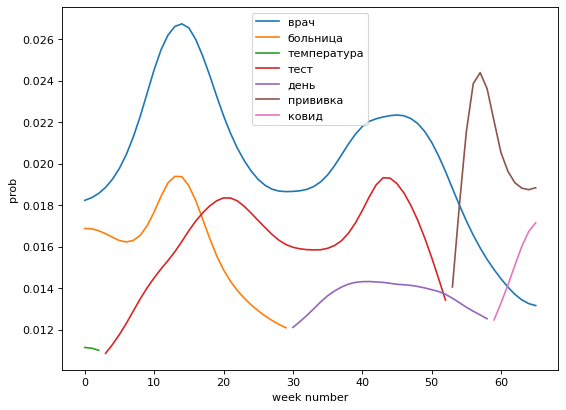

In [28]:
visByTopicId(model, topicid = 2, topn = 3).show()

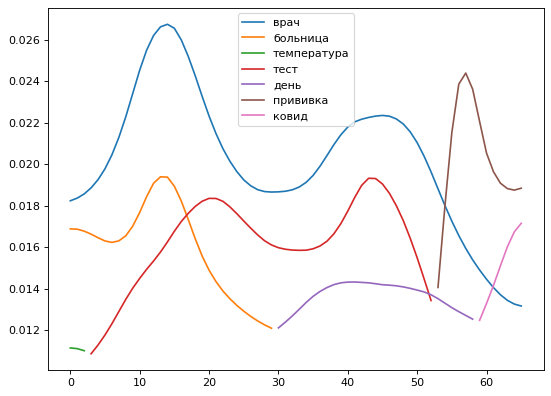

<module 'matplotlib.pyplot' from '/home/mchelushkin/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [23]:
visByTopicId(model, topicid = 2, topn = 3)